In [175]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import json



In [176]:
def unique_points(points):    
    if len(points) == 0:
        return []
    
    # Use DBSCAN to filter out points that are within a few pixels of each other
    db = DBSCAN(eps=5, min_samples=1).fit(points)
    labels = db.labels_

    # Get unique labels
    unique_labels = set(labels)

    # Create a list to store the filtered points
    filtered_points = []

    for label in unique_labels:
        label_points = points[labels == label]

        # filtered_points.append(label_points[0])
        average_point = np.mean(label_points, axis=0)
        filtered_points.append(average_point)

    return filtered_points

def template_matching(template_gray, main_gray, threshold=0.6, offset=(0,0)):
    res = cv2.matchTemplate(main_gray, template_gray, cv2.TM_CCOEFF_NORMED)

    # Define a threshold to detect the matching areas
    loc = np.where(res >= threshold)

    # Extract the points
    points = np.array(list(zip(*loc[::-1])))

    filtered_points = unique_points(points)

    centered_points = [(pt[0] + offset[0], pt[1] + offset[1]) for pt in filtered_points]

    return centered_points




{'stars': {'bottom_left': {'y': 534.75, 'x': 54.0},
  'top_left': {'y': 52.75, 'x': 56.0},
  'top_right': {'y': 56.75, 'x': 398.0},
  'bottom_right': {'y': 528.75, 'x': 404.75}},
 'age': {'x': 263.5, 'y': 56.0, 'h': 16, 'w': 60},
 'enjoy': {'x': 144.5, 'y': 54.0, 'h': 16, 'w': 100},
 'expected': {'x': 183.0, 'y': 57.5, 'h': 15, 'w': 139},
 'overleaf': {'x': 374.5, 'y': 217.0, 'h': 11, 'w': 88},
 'science_events': {'x': 299.5, 'y': 263.0, 'h': 11, 'w': 90},
 'wop': {'x': 57.5, 'y': 193.0, 'h': 12, 'w': 192},
 'title': {'x': 98.5, 'y': 55.0, 'h': 12, 'w': 75},
 '25over': {'x': 265.0, 'y': 377.5, 'h': 11, 'w': 77},
 'over4': {'x': 301.0, 'y': 489.5, 'h': 10, 'w': 41}}

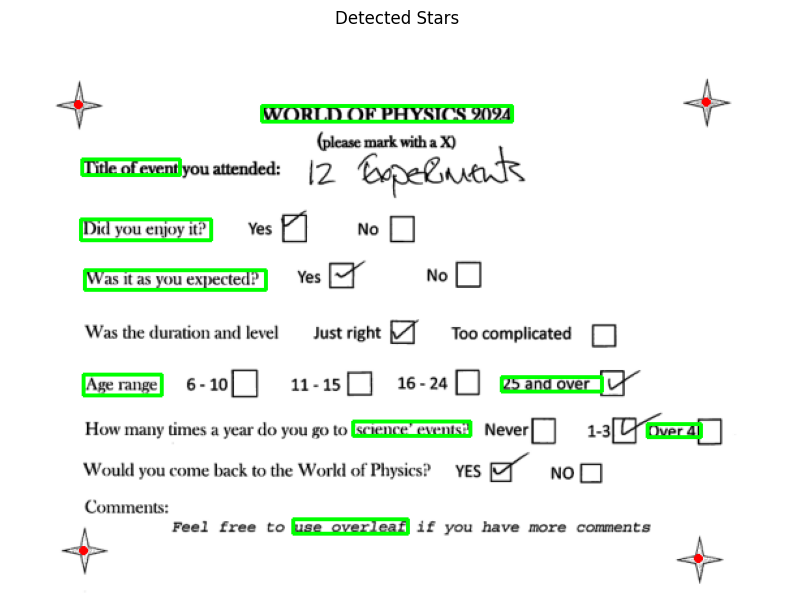

In [177]:
from typing import Dict


def read_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

data_path = Path("./input/womad - 2024/analysis")
assets_path = data_path / "assets"

star = read_image(assets_path / "star.png")
star_core = read_image(assets_path / "star_core.png")
star_bottom = read_image(assets_path / "star_bottom.png")
star_top = read_image(assets_path / "star_top.png")

extra_images = {n: read_image(assets_path / f"{n}.png") for n in [
    "age", "enjoy", "expected", "overleaf", "science_events", "wop", "title", "25over", "over4"
]}

def draw_points(target_image, points, color=(255,0,0), radius=2):
    for pt in points:
        cv2.circle(target_image, (int(pt[0]), int(pt[1])), radius, color, 2)

def draw_rects(target_image, points, size, color=(255,0,0)):
    h, w = size
    for pt in points:
        pt = (int(pt[0]), int(pt[1]))
        cv2.rectangle(target_image, tuple(pt), (pt[0] + w, pt[1] + h), color, 2)

def get_extra_points(name, match_image, target_image):
    return {
        name: {
            "points": template_matching(match_image, target_image, 0.75),
            "image": match_image
        }
    }

def detect_stars(target_image_path):
    target_image = read_image(target_image_path)
    
    star_points = template_matching(star, target_image, 0.6, offset=(19, 19))
    core_points = template_matching(star_core, target_image, 0.6, offset=(9, 11))
    bottom_points = template_matching(star_bottom, target_image, 0.6, offset=(19, 3))
    top_points = template_matching(star_top, target_image, 0.6, offset=(19, 19))

    extra_points = {}
    for key, image in extra_images.items():
        extra_points.update(get_extra_points(key, image, target_image))

    # Use DBSCAN to filter out points that are within a few pixels of each other
    all_points = star_points + core_points + bottom_points + top_points
    all_points = np.array(all_points, dtype=int) 
    all_points = unique_points(all_points)

    return all_points, extra_points

def annotate_image(target_image_path, star_points, extra_points: Dict = None):
    target_image = read_image(target_image_path)
    target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
    draw_points(target_image, star_points, color=(255,0,0))
    
    if extra_points:
        for key, value in extra_points.items():
            key_points = value["points"]
            image = value["image"]
            draw_rects(target_image, key_points, image.shape, color=(0,255,0))
    
    return target_image


def get_coordinate_location(y, x):
    y_pos = "top" if y < 250 else "bottom"
    x_pos = "left" if x < 250 else "right"
    return f"{y_pos}_{x_pos}"

def get_image_info(all_points, extra_points):
    data = {}
    if len(all_points) > 0:
        data["stars"] =  {
            get_coordinate_location(*c): dict(y=float(c[0]), x=float(c[1]))for c in all_points
        }
    for key, values in extra_points.items():
        points = values["points"]
        image = values["image"]
        if len(points) > 0:
            data[key] = dict(
                x=float(points[0][1]), 
                y=float(points[0][0]),
                h=image.shape[0],
                w=image.shape[1],
            )

    return data


image_path = data_path / "004/00 - source images/009.png"
points = detect_stars(image_path)
data = get_image_info(*points)
display(data)

target_image = annotate_image(image_path, *points)
plt.figure(figsize=(10, 10))
plt.imshow(target_image)
plt.title('Detected Stars')
plt.axis('off')
plt.show()


In [178]:

for session_path in sorted(data_path.glob("0??")):
    source_path = session_path / "00 - source images"
    target_path = session_path / "10 - locations"
    target_path.mkdir(exist_ok=True, parents=True)

    for image_path in sorted(source_path.glob("???.png")):
        print(session_path.name, image_path.stem)
        target_image_path = target_path / image_path.name
        data_path = target_image_path.with_suffix(".json")

        points = detect_stars(image_path)

        data = get_image_info(*points)
        data["session"] = session_path.name
        data["image_seq"] = image_path.stem
        data_path.write_text(json.dumps(data))

        target_image = annotate_image(image_path, *points)
        cv2.imwrite(target_image_path, target_image)


000 001
000 002
000 003
000 004
000 005
000 006
000 007
000 008
000 009
000 010
000 011
000 012
000 013
000 014
000 015
000 016
000 017
000 018
001 001
001 002
001 003
001 004
001 005
001 006
001 007
001 008
001 009
001 010
001 011
001 012
001 013
001 014
001 015
001 016
001 017
001 018
001 019
002 001
002 002
003 001
003 002
003 003
003 004
003 005
003 006
003 007
003 008
003 009
003 010
003 011
003 012
003 013
003 014
003 015
003 016
003 017
003 018
003 019
003 020
003 021
003 022
003 023
003 024
003 025
003 026
003 027
003 028
003 029
003 030
003 031
003 032
003 033
003 034
003 035
003 036
003 037
003 038
003 039
003 040
003 041
003 042
003 043
003 044
003 045
004 001
004 002
004 003
004 004
004 005
004 006
004 007
004 008
004 009
004 010
004 011
004 012
004 013
004 014
004 015
004 016
004 017
004 018
004 019
004 020
004 021
004 022
004 023
004 024
004 025
004 026
004 027
004 028
004 029
004 030
004 031
004 032
004 033
004 034
004 035
004 036
004 037
004 038
004 039
004 040
004 041


## Prepare target files

These are the ones we want to align against

In [179]:

def analyse_target_files(image_path):
    points = detect_stars(image_path)

    data = get_image_info(*points)
    data["session"] = session_path.name
    data["image_seq"] = image_path.stem

    image_path.with_suffix(".json").write_text(json.dumps(data))

    target_image = annotate_image(image_path, *points)
    cv2.imwrite(image_path.with_name(f"{image_path.stem} - matched.png"), target_image)


alignment_path = assets_path / "alignment"
analyse_target_files(alignment_path / "left.png")
analyse_target_files(alignment_path / "right.png")
